Raphael David
rearc.io dataquest

# 1) Read data from s3

In [2]:
import s3fs
import pandas as pd
import json

fs = s3fs.S3FileSystem()

with fs.open('s3://greatcandidateraphael/populationData.json', 'rb') as f:
    s3_clientdata = json.load(f)

In [3]:
s3_clientdata

{'data': [{'ID Nation': '01000US',
   'Nation': 'United States',
   'ID Year': 2020,
   'Year': '2020',
   'Population': 326569308,
   'Slug Nation': 'united-states'},
  {'ID Nation': '01000US',
   'Nation': 'United States',
   'ID Year': 2019,
   'Year': '2019',
   'Population': 324697795,
   'Slug Nation': 'united-states'},
  {'ID Nation': '01000US',
   'Nation': 'United States',
   'ID Year': 2018,
   'Year': '2018',
   'Population': 322903030,
   'Slug Nation': 'united-states'},
  {'ID Nation': '01000US',
   'Nation': 'United States',
   'ID Year': 2017,
   'Year': '2017',
   'Population': 321004407,
   'Slug Nation': 'united-states'},
  {'ID Nation': '01000US',
   'Nation': 'United States',
   'ID Year': 2016,
   'Year': '2016',
   'Population': 318558162,
   'Slug Nation': 'united-states'},
  {'ID Nation': '01000US',
   'Nation': 'United States',
   'ID Year': 2015,
   'Year': '2015',
   'Population': 316515021,
   'Slug Nation': 'united-states'},
  {'ID Nation': '01000US',
   'N

# 2) Calculate mean and std deviation of US population

In [4]:
#Create dataframe
populationdf = pd.DataFrame(s3_clientdata['data'])
populationdf.head()

,ID Nation,Nation,ID Year,Year,Population,Slug Nation
0,01000US,United States,2020,2020,326569308,united-states
1,01000US,United States,2019,2019,324697795,united-states
2,01000US,United States,2018,2018,322903030,united-states
3,01000US,United States,2017,2017,321004407,united-states
4,01000US,United States,2016,2016,318558162,united-states


In [5]:
# Convert the "Year" column to a int object
populationdf['Year'] = populationdf['Year'].astype(int)


# Filter the dataframe to only include the years 2013 to 2018
us_population_2013_2018 = populationdf[(populationdf['Year'] >= 2013) & (populationdf['Year'] <= 2018)]

# Calculate the mean and standard deviation of the population in this filtered dataframe
mean_population = us_population_2013_2018['Population'].mean()
std_population = us_population_2013_2018['Population'].std()

print("Mean population:", round(mean_population,2))
print("Standard deviation of population:", round(std_population,2))


Mean population: 317437383.0
Standard deviation of population: 4257089.54


# 3) Read the time series data from s3 and create report for max value for each series_id

In [6]:
#Create dataframe and use \t as a delimiter
seriesdf = pd.read_csv('s3://greatcandidateraphael/files/s3/pr.data.0.Current', sep = '\t',skipinitialspace=True)
seriesdf.head()

,series_id,year,period,value,footnote_codes
0,PRS30006011,1995,Q01,2.6,NaN
1,PRS30006011,1995,Q02,2.1,NaN
2,PRS30006011,1995,Q03,0.9,NaN
3,PRS30006011,1995,Q04,0.1,NaN
4,PRS30006011,1995,Q05,1.4,NaN


In [7]:
# Remove leading and trailing whitespaces from the column names
seriesdf.rename(columns=lambda x: x.strip(), inplace=True)
seriesdf.columns

Index(['series_id', 'year', 'period', 'value', 'footnote_codes'], dtype='object')

In [8]:
# Group the data by "series_id" and "year" to calculate the sum of "value" for each year
grouped = seriesdf.groupby(['series_id', 'year'])['value'].sum().reset_index()
grouped.head()



,series_id,year,value
0,PRS30006011,1995,7.1
1,PRS30006011,1996,-0.5
2,PRS30006011,1997,4.4
3,PRS30006011,1998,4.2
4,PRS30006011,1999,-7.7


In [13]:
# Find the maximum value for each "series_id" and store the corresponding "year"
grouped['best_year'] = grouped.groupby('series_id')['value'].transform(max) == grouped['value']
result = grouped[grouped['best_year'] == True][['series_id', 'year', 'value']]

result.head()


,series_id,year,value
27,PRS30006011,2022,13.300
54,PRS30006012,2021,13.100
59,PRS30006013,1998,733.348
99,PRS30006021,2010,17.700
127,PRS30006022,2010,12.500


In [15]:
# Reset the index and keep only the required columns
result = result.reset_index(drop=True)
result = result[['series_id', 'year', 'value']]
result.head()

,series_id,year,value
0,PRS30006011,2022,13.300
1,PRS30006012,2021,13.100
2,PRS30006013,1998,733.348
3,PRS30006021,2010,17.700
4,PRS30006022,2010,12.500


In [39]:
#Export result
result.to_csv('series_best_value_report.csv')

# 4) Merge dataframes and add in sector and economic measure

In [16]:
#merge the two dataframes together
mergeddf = pd.merge(seriesdf,populationdf, left_on = 'year',right_on = 'Year', how = 'right')
#subset the columns to keep the most relevant
series_population_report = mergeddf[['series_id','year','period','value','Population']]

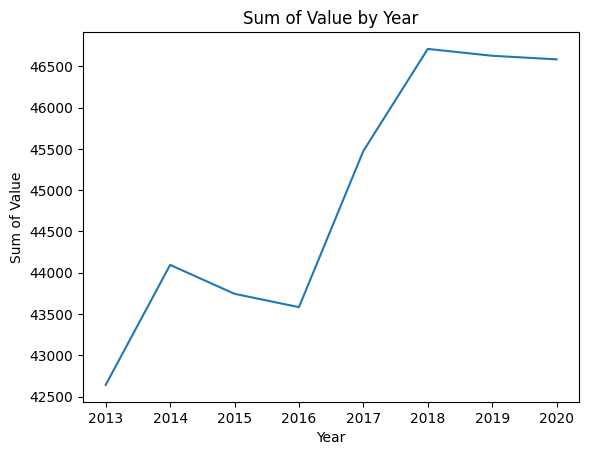

In [21]:
import matplotlib.pyplot as plt

# Group by year
grouped_df = series_population_report.groupby('year')
sum_value_by_year = grouped_df['value'].sum()
# Plot the result of the group-by analysis
sum_value_by_year.plot(kind='line')

# Add a title to the plot
plt.title('Sum of Value by Year')

# Add labels to the x and y axes
plt.xlabel('Year')
plt.ylabel('Sum of Value')


# Show the plot
plt.show()

This graph tells us nothing. What is value? What is causing it to increase? In the next section, we will add in some more details to make the data interpretable

In [22]:
#This function parses the id column from and gets the sector code
#it then creates a new column called 'sector_name' by mapping the sector code to the following
#this is based off the pr.sector file on the bls website
def map_sector(df):
    sector_map = {
    '3000': 'Manufacturing',
    '3100': 'Manufacturing, Durable Goods',
    '3200': 'Manufacturing, Nondurable Goods',
    '8400': 'Business',
    '8500': 'Nonfarm Business',
    '8800': 'Nonfinancial Corporations'
    }
    df['sector_code'] = df['series_id'].str[3:7]
    df['sector_name'] = df['sector_code'].map(sector_map)
    return df

sector = map_sector(series_population_report)
sector.head()

C:\Users\rapha\AppData\Local\Temp\ipykernel_3188\2720739899.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sector_code'] = df['series_id'].str[3:7]
C:\Users\rapha\AppData\Local\Temp\ipykernel_3188\2720739899.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sector_name'] = df['sector_code'].map(sector_map)


,series_id,year,period,value,Population,sector_code,sector_name
0,PRS30006011,2020,Q01,-0.8,326569308,3000,Manufacturing
1,PRS30006011,2020,Q02,-8.3,326569308,3000,Manufacturing
2,PRS30006011,2020,Q03,-6.4,326569308,3000,Manufacturing
3,PRS30006011,2020,Q04,-4.7,326569308,3000,Manufacturing
4,PRS30006011,2020,Q05,-5.1,326569308,3000,Manufacturing


In [23]:
#Similar is done for the economic measure

def map_measure(df):
    measure_map = {
        "01": "Employment",
        "02": "Average weekly hours worked",
        "03": "Hours worked",
        "04": "Output",
        "05": "Current dollar output",
        "06": "Compensation",
        "08": "Nonlabor payments",
        "09": "Labor productivity (output per hour)",
        "10": "Hourly compensation",
        "11": "Unit labor costs",
        "12": "Unit nonlabor costs",
        "13": "Unit nonlabor payments",
        "14": "Implicit price deflator",
        "15": "Real hourly compensation",
        "16": "Output per job",
        "17": "Labor share",
        "18": "Profits",
        "19": "Unit profits",
        "20": "Total unit costs",
    }
    df['measure_code'] = df['series_id'].str[9:11]
    df['measure_name'] = df['measure_code'].map(measure_map)

    return df

measure_and_sector = map_measure(sector)
measure_and_sector.head()

C:\Users\rapha\AppData\Local\Temp\ipykernel_3188\3484912331.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['measure_code'] = df['series_id'].str[9:11]
C:\Users\rapha\AppData\Local\Temp\ipykernel_3188\3484912331.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['measure_name'] = df['measure_code'].map(measure_map)


,series_id,year,period,value,Population,sector_code,sector_name,measure_code,measure_name
0,PRS30006011,2020,Q01,-0.8,326569308,3000,Manufacturing,11,Unit labor costs
1,PRS30006011,2020,Q02,-8.3,326569308,3000,Manufacturing,11,Unit labor costs
2,PRS30006011,2020,Q03,-6.4,326569308,3000,Manufacturing,11,Unit labor costs
3,PRS30006011,2020,Q04,-4.7,326569308,3000,Manufacturing,11,Unit labor costs
4,PRS30006011,2020,Q05,-5.1,326569308,3000,Manufacturing,11,Unit labor costs


In [24]:
measure_and_sector['sector_name'].value_counts()

Nonfinancial Corporations          2280
Business                           1800
Nonfarm Business                   1800
Manufacturing                      1320
Manufacturing, Durable Goods       1320
Manufacturing, Nondurable Goods    1320
Name: sector_name, dtype: int64

In [25]:
measure_and_sector['measure_name'].value_counts()

Unit labor costs               480
Unit nonlabor costs            480
Unit nonlabor payments         480
Employment                     280
Average weekly hours worked    280
Hours worked                   280
Name: measure_name, dtype: int64

# 5) Analyze employment data

There are a couple of different measures -- we will focus on employment. In this dataset employment is a rate that represent the number of people employed in that sector per time period

In [26]:
#filter for only employment data 
employment = measure_and_sector[measure_and_sector['measure_name'] == 'Employment']
employment.head()


,series_id,year,period,value,Population,sector_code,sector_name,measure_code,measure_name
96,PRS30006101,2020,Q01,3.4,326569308,3000,Manufacturing,01,Employment
97,PRS30006101,2020,Q02,10.5,326569308,3000,Manufacturing,01,Employment
98,PRS30006101,2020,Q03,7.2,326569308,3000,Manufacturing,01,Employment
99,PRS30006101,2020,Q04,6.7,326569308,3000,Manufacturing,01,Employment
100,PRS30006101,2020,Q05,7.0,326569308,3000,Manufacturing,01,Employment


In [27]:
#group by year and sector
employment_grouped = employment.groupby(['year','sector_name'])['value'].sum().reset_index()
employment_grouped.head()

,year,sector_name,value
0,2013,Business,6.8
1,2013,Manufacturing,2.7
2,2013,"Manufacturing, Durable Goods",-1.1
3,2013,"Manufacturing, Nondurable Goods",9.6
4,2013,Nonfarm Business,6.1


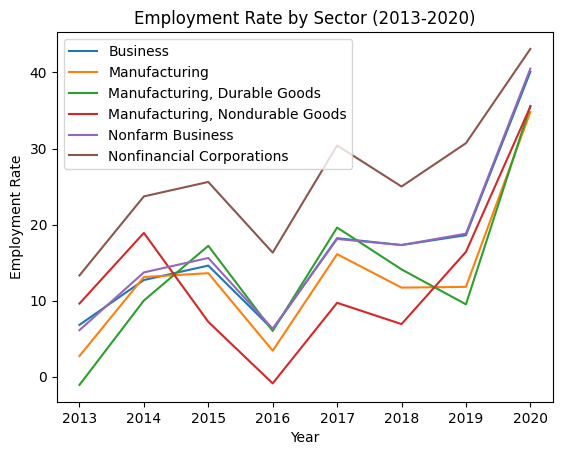

In [28]:
import matplotlib.pyplot as plt

#sector names 
sectors = employment_grouped['sector_name'].unique()

#plot the line chart, with different colors for each sector
for sector in sectors:
    x = employment_grouped.loc[employment_grouped['sector_name'] == sector, 'year']
    y = employment_grouped.loc[employment_grouped['sector_name'] == sector, 'value']
    plt.plot(x, y, label=sector)

#add legend and labels
plt.legend()
plt.xlabel('Year')
plt.ylabel('Employment Rate')
plt.title('Employment Rate by Sector (2013-2020)')

#show plot
plt.show()

This graph shows the employment rate by sector

- We see **positive employment rates** for **every year in all sectors** with the exception of Manufacturing, Durable Goods in 2013 and  Manufacturing, Nondurable Goods in 2016
- **Nonfinancial** corporations sector accounts for the **highest rates of employment**
- **2016** was the year with the **biggest hit** to employment rates, but the rate bounces back up
- **2019 -2020** was the **largest spike** in employment
    - Now that we break this up into sectors, we can see that 2019 has a large spike where as in the aggregated graph we cannot observe this.

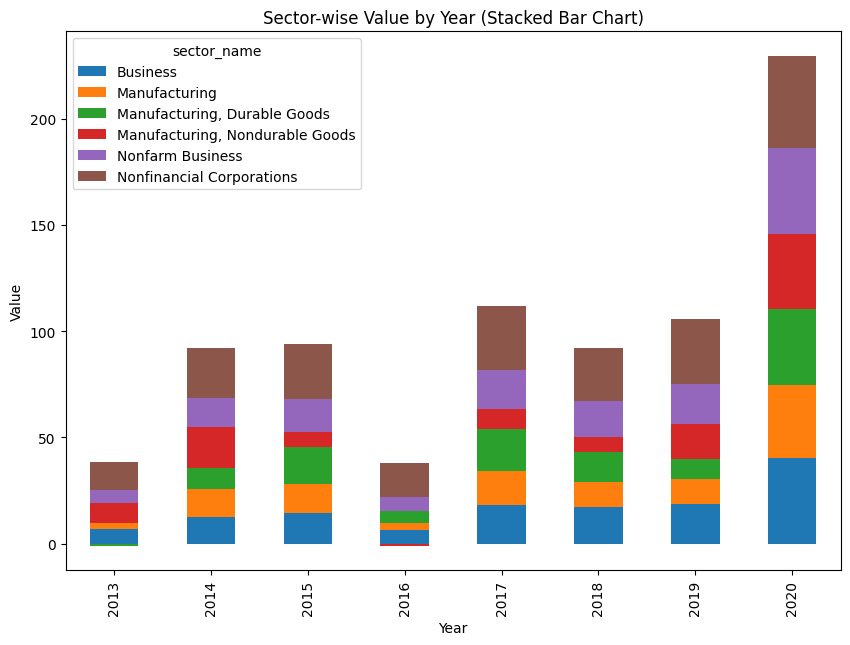

In [30]:
#Going to create a stacked bar chart to see the breakdownb by sector per year

# Create a pivot table of the groupby data
df_pivot = employment_grouped.pivot(index='year', columns='sector_name', values='value')

# Plot the stacked bar chart
df_pivot.plot(kind='bar', stacked=True, figsize=(10,7))

# Add labels and title to the chart
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Sector-wise Value by Year (Stacked Bar Chart)')

# Show the plot
plt.show()

This graph shows the same as above, just as a stacked bar. Here its easier to see the percentage of employment each sector takes per year. 

In [31]:
df_pivot['total'] = df_pivot.sum(axis=1)
df_pivot_percent = df_pivot.div(df_pivot['total'], axis=0) * 100
df_pivot_percent

sector_name,Business,Manufacturing,"Manufacturing, Durable Goods","Manufacturing, Nondurable Goods",Nonfarm Business,Nonfinancial Corporations,total
year,,,,,,,
2013,18.181818,7.219251,-2.941176,25.668449,16.310160,35.561497,100.0
2014,13.789359,14.223670,10.857763,20.521173,14.875136,25.732899,100.0
2015,15.565032,14.498934,18.336887,7.675906,16.631130,27.292111,100.0
2016,16.621984,9.115282,16.085791,-2.412869,16.890080,43.699732,100.0
2017,16.235504,14.362177,17.484389,8.652988,16.146298,27.118644,100.0
2018,18.743229,12.676056,15.276273,7.475623,18.743229,27.085590,100.0
2019,17.580340,11.153119,8.979206,15.500945,17.769376,29.017013,100.0
2020,17.465157,15.156794,15.505226,15.461672,17.639373,18.771777,100.0


Text(0.5, 1.0, 'Percent makeup of Employment by Sector')

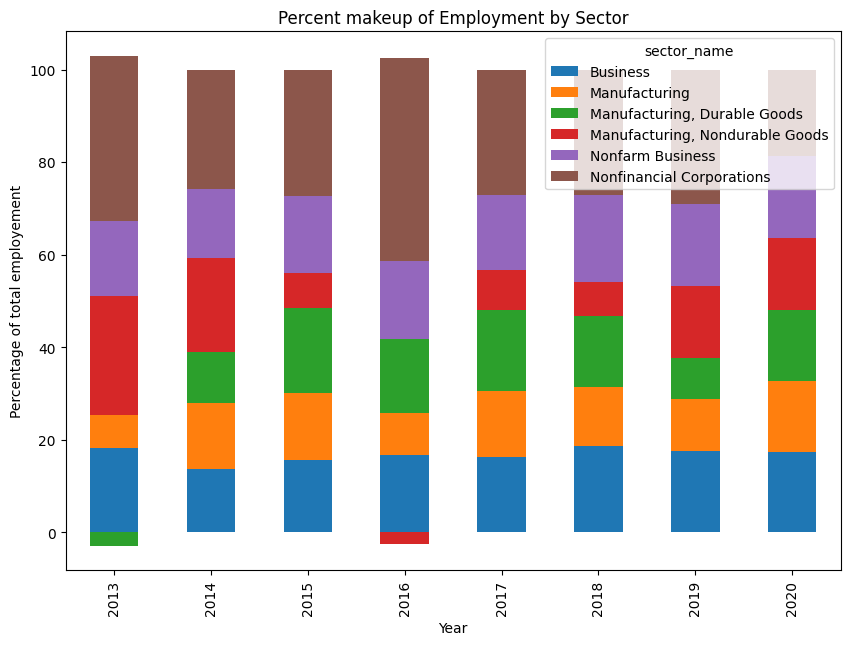

In [32]:
df_pivot_percent.drop(['total'], axis = 1 ,inplace = True)

df_pivot_percent.plot(kind='bar', stacked=True, figsize=(10,7))
plt.xlabel('Year')
plt.ylabel('Percentage of total employement')
plt.title('Percent makeup of Employment by Sector')

This graph is the same as above, just shown as a percentage. Here we can see that manufacturing, durable goods & manufacturing, nondurable goods are the only two sectors to have a negative employment rate in 2013 and 2016 respectively.

# 6) Forecasting

This section will attempt to do some forecasting of employment rates for the future


Will implement the simple moving average, since it is easy to implement and does not weight recent data with more importance.

If we are to create a time series forecast, we know that there will most definitely be an issue because of **COVID**. So how do we account for this? We can use confidence intervals to get a pessimistic and optimistic forecast, and since we kind of know what will happen, we can select the pessimistic forecast.

In [42]:
employment_grouped

sectors = employment_grouped['sector_name'].unique()

def moving_average(data, window):
    return data.rolling(window).mean()
    
def create_forecast(data, window, alpha, num_future_windows):
    moving_avg = moving_average(data, window)
    std = data.rolling(window).std()
    forecast = pd.DataFrame(index=data.index, columns=['Value', 'Lower Bound', 'Upper Bound'])
    forecast['Value'] = moving_avg
    forecast['Lower Bound'] = moving_avg - (std * alpha)
    forecast['Upper Bound'] = moving_avg + (std * alpha)
    
    last_year = forecast.index[-1]
    future_years = [last_year + i + 1 for i in range(num_future_windows)]
    for year in future_years:
        forecast.loc[year] = moving_average(forecast.loc[:year].Value, window).iloc[-1]
        forecast.loc[year, 'Lower Bound'] = forecast.loc[year, 'Value'] - (forecast.loc[:year, 'Value'].rolling(window).std().iloc[-1] * alpha)
        forecast.loc[year, 'Upper Bound'] = forecast.loc[year, 'Value'] + (forecast.loc[:year, 'Value'].rolling(window).std().iloc[-1] * alpha)
    
    return forecast


num_future_windows = 3 # the number of future windows to predict

window = 3 # the window size for the moving average
alpha = 2 # the number of standard deviations used to create the confidence interval

forecasts = {}
for sector in sectors:
    df = employment_grouped[employment_grouped['sector_name'] == sector].set_index('year')
    df['value'] = df['value'].astype(float)
    
    forecast = create_forecast(df['value'], window, alpha,num_future_windows)
    forecasts[sector] = forecast
    
    # optimistic outlook
    optimistic = forecast[['Value']] + forecast[['Upper Bound']]
    # pessimistic outlook
    pessimistic = forecast[['Value']] - forecast[['Lower Bound']]




In [43]:
forecasts

{'Business':           Value  Lower Bound  Upper Bound
 year                                     
 2013        NaN          NaN          NaN
 2014        NaN          NaN          NaN
 2015  11.366667     3.231967    19.501366
 2016  11.166667     2.356824    19.976510
 2017  13.000000     0.684157    25.315843
 2018  13.900000     0.532876    27.267124
 2019  18.033333    16.701668    19.364999
 2020  25.333333    -0.276300    50.942967
 2021  19.088889    11.198081    26.979697
 2022  20.818519    14.370353    27.266684
 2023  21.746914    19.048935    24.444892,
 'Manufacturing':           Value  Lower Bound  Upper Bound
 year                                     
 2013        NaN          NaN          NaN
 2014        NaN          NaN          NaN
 2015   9.800000    -2.507721    22.107721
 2016  10.033333    -1.466812    21.533478
 2017  11.033333    -2.422273    24.488939
 2018  10.400000    -2.498062    23.298062
 2019  13.200000     8.176057    18.223943
 2020  19.433333    -7.1

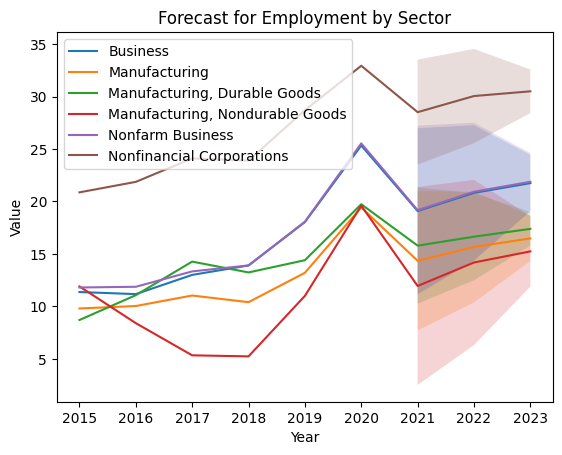

In [46]:
import matplotlib.pyplot as plt

for sector in sectors:
    forecast = forecasts[sector]
    plt.plot(forecast.index, forecast['Value'], label=sector)
    
    #shaded region for
    lower = forecast[forecast.index >= 2021]['Lower Bound']
    upper = forecast[forecast.index >= 2021]['Upper Bound']
    plt.fill_between(forecast[forecast.index >= 2021].index, lower, upper, alpha=0.2)
    
plt.legend()
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Forecast for Employment by Sector')
plt.show()


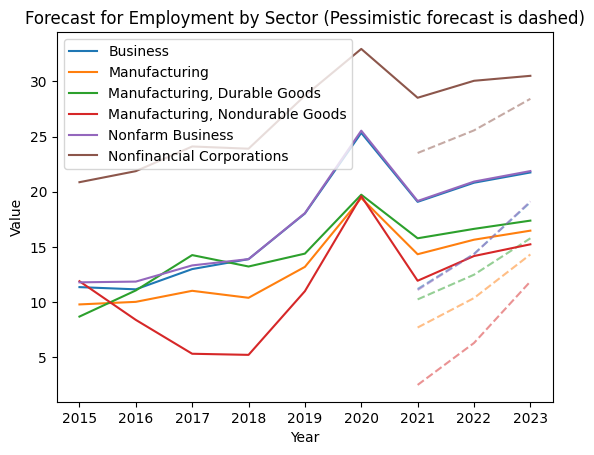

In [50]:
import matplotlib.pyplot as plt

for sector in sectors:
    forecast = forecasts[sector]
    line, = plt.plot(forecast.index, forecast['Value'], label=sector)
    color = line.get_color()
    
    lower = forecast[forecast.index >= 2021]['Lower Bound']
    plt.plot(forecast[forecast.index >= 2021].index, lower, '--', color=color, alpha=0.5)
    
plt.legend()
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Forecast for Employment by Sector (Pessimistic forecast is dashed)')
plt.show()


Here we created a forecast using the simple moving average method with a window of 3 time periods and an alpha of 2 standard deviations. We predicted for 3 periods into the future and graphed the pessimistic outlook since we know COVID had a negative effect on the economy.

In [56]:
# Recreate master df this time with the predictions upper and lower

forecasts_list = [v for k, v in forecasts.items()]
forecast_df = pd.concat(forecasts_list, keys=forecasts.keys(), names=['Sector'])
forecast_df = forecast_df.reset_index()

forecast_df

,Sector,year,Value,Lower Bound,Upper Bound
0,Business,2013,NaN,NaN,NaN
1,Business,2014,NaN,NaN,NaN
2,Business,2015,11.366667,3.231967,19.501366
3,Business,2016,11.166667,2.356824,19.976510
4,Business,2017,13.000000,0.684157,25.315843
...,...,...,...,...,...
61,Nonfinancial Corporations,2019,28.700000,22.284394,35.115606
62,Nonfinancial Corporations,2020,32.933333,14.424597,51.442070
63,Nonfinancial Corporations,2021,28.511111,23.510255,33.511967
64,Nonfinancial Corporations,2022,30.048148,25.557950,34.538347


In [73]:
import numpy as np

def calculate_rmse(actual, forecast):
    mse = ((actual - forecast) ** 2).mean()
    rmse = np.sqrt(mse)
    return rmse

RMSE for 2020: nan


In [85]:
#example calculating the RMSE between the 2020 prediction and the 2020 actual
rmse_2020_business = calculate_rmse(employment_grouped['value'][42],forecast_df[forecast_df['year'] == 2020]['Value'][7])
print('The RMSE for business in 2020 is: ', rmse_2020_business)

The RMSE for business in 2020 is:  14.766666666666666


 The validity of the data can be checked using root mean square error (RMSE), or also by checking the BLS data and comparing it to 2020 and 2021 whenever it is published. We see that the RMSE isn't very good for the the one example as shown above.